In [1]:
%pip install -q matplotlib
%pip install -q numpy
%pip install -q torch
import matplotlib.pyplot as plt
import numpy as np
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
# !curl -O https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
# !curl -O https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
from Gridworld_model import *
game = Gridworld(size=4, mode='play')
game.display()

array([[' ', ' ', ' ', '+'],
       [' ', ' ', ' ', ' '],
       ['W', ' ', ' ', ' '],
       [' ', '-', ' ', 'P']], dtype='<U2')

In [3]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

# 網路參數設定

In [15]:
import numpy as np
import torch
from Gridworld_model import Gridworld
from IPython.display import clear_output
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape 
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

# 將原本的naive dqn加入Experience Replay Buffer

## reply buffer

In [ ]:
from collections import deque, namedtuple
Transition = namedtuple('T', ['s', 'a', 'r', 's1', 'done'])

import argparse, random, collections, os, sys
from typing import Deque
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───────────────────────────── replay buffer ────────────────────────── #
Transition = collections.namedtuple("T", ["s", "a", "r", "s1", "done"])

class ReplayBuffer:
    def __init__(self, capacity: int = 10000):
        self.buf: Deque[Transition] = collections.deque(maxlen=capacity)

    def add(self, *args):
        self.buf.append(Transition(*args))

    def sample(self, batch_size: int):
        batch = random.sample(self.buf, batch_size)
        t = Transition(*zip(*batch))
        return (
            torch.tensor(t.s, dtype=torch.float32, device=DEVICE),
            torch.tensor(t.a, dtype=torch.int64,  device=DEVICE).unsqueeze(1),
            torch.tensor(t.r, dtype=torch.float32, device=DEVICE).unsqueeze(1),
            torch.tensor(t.s1, dtype=torch.float32, device=DEVICE),
            torch.tensor(t.done, dtype=torch.float32, device=DEVICE).unsqueeze(1),
        )

    def __len__(self):
        return len(self.buf)

## double_dqn network

Ep    0 | ε=0.998 | avg loss (last100)=0.0000
Ep  100 | ε=0.463 | avg loss (last100)=0.1097
Ep  200 | ε=0.114 | avg loss (last100)=0.1667
Ep  300 | ε=0.100 | avg loss (last100)=0.2344
Ep  400 | ε=0.100 | avg loss (last100)=0.1400
Ep  500 | ε=0.100 | avg loss (last100)=0.0594
Ep  600 | ε=0.100 | avg loss (last100)=0.0429
Ep  700 | ε=0.100 | avg loss (last100)=0.0331
Ep  800 | ε=0.100 | avg loss (last100)=0.0307
Ep  900 | ε=0.100 | avg loss (last100)=0.0238
Ep 1000 | ε=0.100 | avg loss (last100)=0.0193
Ep 1100 | ε=0.100 | avg loss (last100)=0.0159
Ep 1200 | ε=0.100 | avg loss (last100)=0.0141
Ep 1300 | ε=0.100 | avg loss (last100)=0.0124
Ep 1400 | ε=0.100 | avg loss (last100)=0.0110
Ep 1500 | ε=0.100 | avg loss (last100)=0.0091
Ep 1600 | ε=0.100 | avg loss (last100)=0.0090
Ep 1700 | ε=0.100 | avg loss (last100)=0.0073
Ep 1800 | ε=0.100 | avg loss (last100)=0.0058
Ep 1900 | ε=0.100 | avg loss (last100)=0.0053
Ep 2000 | ε=0.100 | avg loss (last100)=0.0039
Ep 2100 | ε=0.100 | avg loss (last

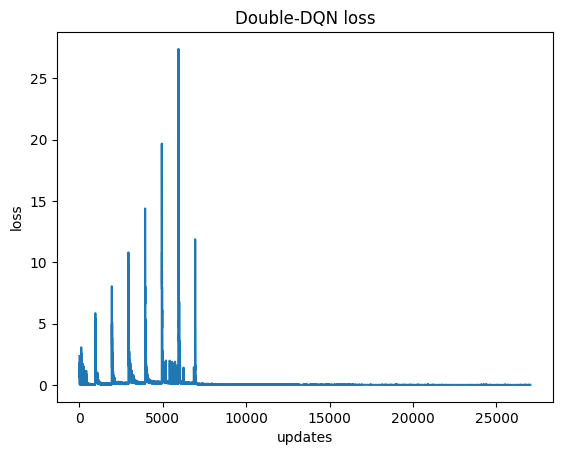

In [16]:
"""double_dqn.py
=================================
Minimal, self‑contained Double‑DQN implementation for the 4×4 Gridworld
(static / player / random modes supported).

Usage (static mode example) ────────────────────────────────────────────
$ python double_dqn.py --mode static --episodes 3000

Required file: Gridworld_model.py (from DRL‑in‑Action)
-----------------------------------------------------------------------
"""
class DQN(nn.Module):
    def __init__(self, in_dim: int = 64, hidden1: int = 150, hidden2: int = 100, out_dim: int = 4):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Linear(hidden2, out_dim)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.layers(x)

# ─────────────────────────────── agent ─────────────────────────────── #
class DoubleDQNAgent:
    def __init__(self, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.1, eps_decay_steps=5000,
                 buffer_size=10000, batch_size=64, sync_freq=1000):
        self.gamma = gamma
        self.batch_size = batch_size
        self.sync_freq = sync_freq
        self.epsilon = epsilon_start
        self.eps_end = epsilon_end
        self.eps_decay = (epsilon_start - epsilon_end) / eps_decay_steps

        self.online_net = DQN().to(DEVICE)
        self.target_net = DQN().to(DEVICE)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.target_net.eval()

        self.optim = torch.optim.Adam(self.online_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(buffer_size)
        self.global_steps = 0

        self.action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}

    # ε‑greedy policy
    def choose_action(self, state: torch.Tensor):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        with torch.no_grad():
            return int(torch.argmax(self.online_net(state)))

    def decay_epsilon(self):
        if self.epsilon > self.eps_end:
            self.epsilon -= self.eps_decay
            if self.epsilon < self.eps_end:
                self.epsilon = self.eps_end

    # one gradient step using Double‑DQN target
    def learn(self):
        if len(self.buffer) < self.batch_size:
            return None

        s, a, r, s1, d = self.buffer.sample(self.batch_size)

        # online net selects action
        with torch.no_grad():
            next_actions = torch.argmax(self.online_net(s1), dim=1, keepdim=True)
            # target net evaluates Q
            next_q = self.target_net(s1).gather(1, next_actions)
            y = r + (1 - d) * self.gamma * next_q

        q_pred = self.online_net(s).gather(1, a)
        loss = self.loss_fn(q_pred, y)

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        # periodically update target network
        if self.global_steps % self.sync_freq == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())

        return float(loss.item())
# ──────────────────────────────── train ────────────────────────────── #

def train(mode='static', episodes=3000, render_interval=0):
    agent = DoubleDQNAgent()
    losses = []

    for ep in range(episodes):
        env = Gridworld(size=4, mode=mode)
        state = torch.tensor(env.board.render_np().reshape(64) + np.random.rand(64)/10.0,
                             dtype=torch.float32, device=DEVICE)
        done = False
        while not done:
            action_idx = agent.choose_action(state)
            env.makeMove(agent.action_set[action_idx])
            next_state = torch.tensor(env.board.render_np().reshape(64) + np.random.rand(64)/10.0,
                                      dtype=torch.float32, device=DEVICE)
            reward = env.reward()
            done = abs(reward) == 10

            agent.buffer.add(state.cpu().numpy(), action_idx, reward, next_state.cpu().numpy(), done)
            agent.global_steps += 1
            loss = agent.learn()
            if loss is not None:
                losses.append(loss)

            state = next_state
            agent.decay_epsilon()

        if ep % 100 == 0:
            avg_loss = np.mean(losses[-100:]) if losses else 0
            print(f"Ep {ep:4d} | ε={agent.epsilon:.3f} | avg loss (last100)={avg_loss:.4f}")

    # plot
    try:
        import matplotlib.pyplot as plt
        if losses:
            plt.plot(losses)
            plt.xlabel('updates'); plt.ylabel('loss'); plt.title('Double‑DQN loss'); plt.show()
    except ImportError:
        pass

if __name__ == '__main__':
    p = argparse.ArgumentParser()
    p.add_argument('--mode', choices=['static', 'player', 'random'], default='static')
    p.add_argument('--episodes', type=int, default=3000)
    args, _ = p.parse_known_args()
    train(mode=args.mode, episodes=args.episodes)

## dueling dqn

Ep    0 | ε=0.996 | avg loss=0.0000
Ep  100 | ε=0.635 | avg loss=0.1053
Ep  200 | ε=0.462 | avg loss=0.5347
Ep  300 | ε=0.365 | avg loss=0.1249
Ep  400 | ε=0.270 | avg loss=0.1039
Ep  500 | ε=0.191 | avg loss=0.0821
Ep  600 | ε=0.124 | avg loss=0.0605
Ep  700 | ε=0.100 | avg loss=0.0357
Ep  800 | ε=0.100 | avg loss=0.0314
Ep  900 | ε=0.100 | avg loss=0.0267
Ep 1000 | ε=0.100 | avg loss=0.0242
Ep 1100 | ε=0.100 | avg loss=0.0209
Ep 1200 | ε=0.100 | avg loss=0.0196
Ep 1300 | ε=0.100 | avg loss=0.0169
Ep 1400 | ε=0.100 | avg loss=0.0156
Ep 1500 | ε=0.100 | avg loss=0.0140
Ep 1600 | ε=0.100 | avg loss=0.0123
Ep 1700 | ε=0.100 | avg loss=0.0110
Ep 1800 | ε=0.100 | avg loss=0.0100
Ep 1900 | ε=0.100 | avg loss=0.0103
Ep 2000 | ε=0.100 | avg loss=0.0085
Ep 2100 | ε=0.100 | avg loss=0.0077
Ep 2200 | ε=0.100 | avg loss=0.0063
Ep 2300 | ε=0.100 | avg loss=0.0073
Ep 2400 | ε=0.100 | avg loss=0.0065
Ep 2500 | ε=0.100 | avg loss=0.0053
Ep 2600 | ε=0.100 | avg loss=0.0046
Ep 2700 | ε=0.100 | avg loss

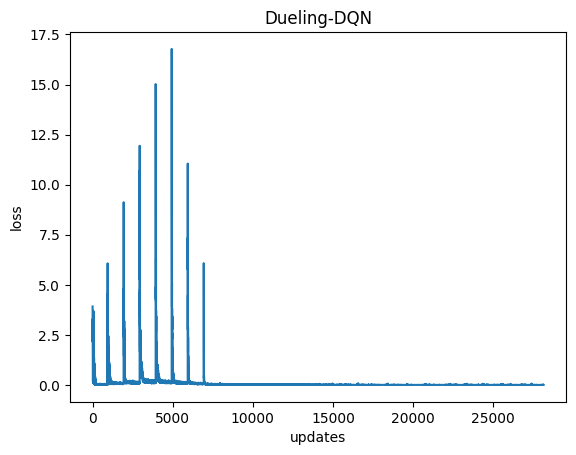

In [17]:
"""dueling_dqn.py
================================
Minimal, self‑contained Dueling‑DQN for the 4×4 Gridworld.

Usage ────────────────────────────────────────────────────
$ python dueling_dqn.py --mode player --episodes 5000
"""


# ─────────────────────────────── network ────────────────────────────── #
class DuelingDQN(nn.Module):
    def __init__(self, in_dim=64, hidden1=150, hidden2=100, out_dim=4):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(in_dim, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU())
        self.value   = nn.Linear(hidden2, 1)      # V(s)
        self.adv     = nn.Linear(hidden2, out_dim) # A(s,a)
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        f = self.feature(x)
        v = self.value(f)
        a = self.adv(f)
        q = v + a - a.mean(dim=1, keepdim=True)
        return q

# ─────────────────────────────── agent ─────────────────────────────── #
class DuelingAgent:
    def __init__(self, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.1, eps_decay_steps=7000,
                 buffer_size=10000, batch_size=64, sync_freq=1000):
        self.gamma = gamma
        self.batch = batch_size
        self.sync_freq = sync_freq
        self.epsilon = epsilon_start
        self.eps_end = epsilon_end
        self.eps_decay = (epsilon_start - epsilon_end) / eps_decay_steps

        self.policy_net = DuelingDQN().to(DEVICE)
        self.target_net = DuelingDQN().to(DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optim = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(buffer_size)
        self.global_steps = 0

        self.action_set = {0:'u',1:'d',2:'l',3:'r'}

    def choose(self, state):
        if random.random() < self.epsilon:
            return random.randint(0,3)
        with torch.no_grad():
            return int(torch.argmax(self.policy_net(state)))
    def decay_eps(self):
        if self.epsilon > self.eps_end:
            self.epsilon -= self.eps_decay
            if self.epsilon < self.eps_end:
                self.epsilon = self.eps_end

    def learn(self):
        if len(self.buffer) < self.batch:
            return None
        s,a,r,s1,d = self.buffer.sample(self.batch)
        with torch.no_grad():
            q_next = self.target_net(s1).max(1, keepdim=True).values
            y = r + (1-d)*self.gamma*q_next
        q_pred = self.policy_net(s).gather(1, a)
        loss = self.loss_fn(q_pred, y)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        if self.global_steps % self.sync_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return float(loss.item())

# ─────────────────────────────── train ─────────────────────────────── #

def train(mode='player', episodes=5000):
    agent = DuelingAgent()
    losses=[]
    for ep in range(episodes):
        env = Gridworld(size=4, mode=mode)
        state = torch.tensor(env.board.render_np().reshape(64)+np.random.rand(64)/10.0,
                             dtype=torch.float32, device=DEVICE)
        done=False
        while not done:
            act_idx = agent.choose(state)
            env.makeMove(agent.action_set[act_idx])
            next_state = torch.tensor(env.board.render_np().reshape(64)+np.random.rand(64)/10.0,
                                     dtype=torch.float32, device=DEVICE)
            reward = env.reward()
            done = abs(reward)==10
            agent.buffer.add(state.cpu().numpy(), act_idx, reward, next_state.cpu().numpy(), done)
            agent.global_steps+=1
            loss=agent.learn()
            if loss is not None:
                losses.append(loss)
            state=next_state
            agent.decay_eps()
        if ep%100==0:
            avg=np.mean(losses[-100:]) if losses else 0
            print(f"Ep {ep:4d} | ε={agent.epsilon:.3f} | avg loss={avg:.4f}")

    try:
        import matplotlib.pyplot as plt
        if losses:
            plt.plot(losses); plt.xlabel('updates'); plt.ylabel('loss'); plt.title('Dueling‑DQN'); plt.show()
    except ImportError:
        pass

if __name__=='__main__':
    ap=argparse.ArgumentParser()
    ap.add_argument('--mode',choices=['static','player','random'],default='player')
    ap.add_argument('--episodes',type=int,default=5000)
    args, _ = ap.parse_known_args()
    train(mode=args.mode, episodes=args.episodes)